<a href="https://colab.research.google.com/github/crlsyajie/Machine-Learning-Models/blob/main/LibericaXExcelsa04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.morphology import skeletonize
from skimage.util import invert

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
excelsa_dir = '/content/drive/MyDrive/LibericaxExcelsa/Excelsa'
liberica_dir = '/content/drive/MyDrive/LibericaxExcelsa/Liberica'
image_size = (224, 224)
label_map = {'Excelsa': 0, 'Liberica': 1}


In [ ]:
def calculate_eccentricity(contour):
    if len(contour) < 5:
        return 0
    ellipse = cv2.fitEllipse(contour)
    major = max(ellipse[1])
    minor = min(ellipse[1])
    return np.sqrt(1 - (minor / major)**2) if major != 0 else 0

def preprocess_and_extract(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None

    image = cv2.resize(image, image_size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Stronger background removal
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    c = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)

    bean_only = cv2.bitwise_and(image, image, mask=mask)

    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    aspect_ratio = float(w) / h
    perimeter = cv2.arcLength(c, True)
    circularity = 4 * np.pi * (area / (perimeter**2)) if perimeter != 0 else 0
    eccentricity = calculate_eccentricity(c)

    hu = cv2.HuMoments(cv2.moments(c)).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    hull = cv2.convexHull(c)
    angles = []
    for i in range(len(hull)):
        p1 = hull[i - 1][0]
        p2 = hull[i][0]
        p3 = hull[(i + 1) % len(hull)][0]
        v1 = p1 - p2
        v2 = p3 - p2
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10))
        angles.append(np.degrees(angle))
    tip_sharpness = np.mean(sorted(angles)[:2])

    binarized = (closed > 0).astype(np.uint8)
    skeleton = skeletonize(invert(binarized))
    coords = np.argwhere(skeleton)

    if coords.shape[0] < 2:
        return None, None

    curve_x = coords[:,1]
    curve_y = coords[:,0]
    coeffs = np.polyfit(curve_x, curve_y, deg=2)

    # S-curve prominence = abs(a) where y = ax² + bx + c
    s_curve_strength = abs(coeffs[0])

    features = [
        area, w, h, aspect_ratio, circularity,
        eccentricity, tip_sharpness, s_curve_strength
    ] + coeffs.tolist() + hu_log.tolist()

    return bean_only / 255.0, features


In [ ]:
X_shape, y = [], []

def process_folder(folder_path, label_name):
    label = label_map[label_name]
    for file in tqdm(os.listdir(folder_path), desc=f"Processing {label_name}"):
        if not file.lower().endswith(('.jpg', '.png')):
            continue
        path = os.path.join(folder_path, file)
        _, features = preprocess_and_extract(path)
        if features is not None:
            X_shape.append(features)
            y.append(label)
        else:
            print(f"⚠️ Skipped {file}: feature extraction failed")

process_folder(liberica_dir, 'Liberica')
process_folder(excelsa_dir, 'Excelsa')


Processing Excelsa: 100%|██████████| 55/55 [00:02<00:00, 22.40it/s]


In [ ]:
if len(X_shape) == 0:
    raise ValueError("❌ No features extracted.")

X_shape = StandardScaler().fit_transform(np.array(X_shape))
y = np.array(y)

X_shape_train, X_shape_val, y_train, y_val = train_test_split(
    X_shape, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_shape_train, y_train)


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

     Excelsa       1.00      1.00      1.00        11
    Liberica       1.00      1.00      1.00        12

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



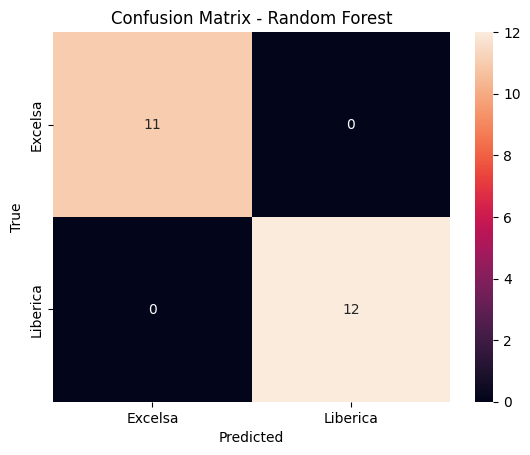

In [ ]:
y_val_pred = rf_model.predict(X_shape_val)
print(classification_report(y_val, y_val_pred, target_names=['Excelsa', 'Liberica']))

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d',
            xticklabels=['Excelsa', 'Liberica'], yticklabels=['Excelsa', 'Liberica'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()


Saving Screenshot 2025-07-31 191744.png to Screenshot 2025-07-31 191744.png


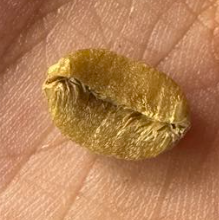

In [ ]:
from google.colab import files
from IPython.display import Image as IPImage, display

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
display(IPImage(filename=img_path))

def predict_rf(img_path, threshold=0.6):
    _, features = preprocess_and_extract(img_path)
    if features is None:
        print(" Feature extraction failed.")
        return

    shape_input = np.expand_dims(features, axis=0)
    proba = rf_model.predict_proba(shape_input)[0]
    classes = ['Excelsa', 'Liberica']

    s_curve_strength = features[5]

    print(" Prediction Confidence:")
    for i, score in enumerate(proba):
        print(f"  {classes[i]}: {score * 100:.2f}%")

    print(f"\n S-Curve Strength: {s_curve_strength:.5f}")

    # S-curve
    rounded_curve = round(s_curve_strength, 5)

    if rounded_curve >= 0.6:
      print("\n Final Prediction (by S-curve): Liberica (prominent S-curve)")
    elif rounded_curve <= 0.5:
      print("\n Final Prediction (by S-curve): Excelsa (straight/slight S-curve)")
    else:
      max_idx = np.argmax(proba)
      max_score = proba[max_idx]
      if max_score >= threshold:
          print(f"\n Final Prediction (by model): {classes[max_idx]} (≥ {threshold*100:.0f}%)")
      else:
          print("\n Final Prediction: Other or Uncertain")


In [ ]:
predict_rf(img_path, threshold=0.6)


 Prediction Confidence:
  Excelsa: 64.00%
  Liberica: 36.00%

 S-Curve Strength: 0.83130

 Final Prediction (by S-curve): Liberica (prominent S-curve)
